## 1. *Import libraries*

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

## 2. *Load data*

In [3]:
data_csv = pd.read_csv("Data.csv")
data = data_csv.iloc[:,1:2]
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

## 3. *Training and test data*

In [4]:
seq_len = 4
def data_gen(data,seq_len = 4):
  x, y = [], []
  for i in range(len(data)-seq_len-1):
    x.append(np.array(data[i:(i+seq_len)])) # appends 4 time steps
    y.append(np.array(data[i+seq_len])) # append one time step
  return x,y
x,y = data_gen(data,seq_len = 4)
train_size = int(len(x) * 0.8)

In the following cell the sequence which is used as input along with the target values is depicted

you can change the window length in order to see the sequence format inside the whole data

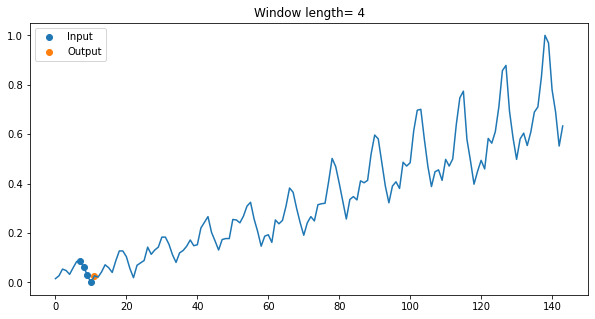

In [5]:
def f(data,ind,window=4):
    X,Y=data_gen(data,seq_len = window)
    X=np.array(X)
    Y=np.array(Y)
    index=range(ind,ind+window,1)
    plt.figure(figsize=[10,5],facecolor='w')
    plt.scatter(index,X[ind,:].reshape(window,),label='Input')
    plt.scatter(index[-1]+1,Y[ind],label='Output')
    plt.plot(np.arange(len(data)),data)
    plt.title('Window length= %i' %window)
    # plt.grid()
    plt.legend()
    plt.show()
f(data,7,window=4)

In [6]:
####################
x_train = x[:train_size]
y_train = y[:train_size]

x_test = x[train_size:]
y_test = y[train_size:]
####################

In [7]:
x_train = torch.from_numpy(np.array(x_train,dtype=np.float32)); x_train=x_train.view(x_train.size(0),seq_len,1) # [N,L,Input_size] if batch first
y_train = torch.from_numpy(np.array(y_train,dtype=np.float32)); y_train=y_train.view(y_train.size(0),1)

x_test = torch.from_numpy(np.array(x_test,dtype=np.float32)); x_test=x_test.view(x_test.size(0),seq_len,1)
y_test = torch.from_numpy(np.array(y_test,dtype=np.float32)); y_test=y_test.view(y_test.size(0),1)

In [8]:
y_train.size()

torch.Size([111, 1])

## 4. *Build the structure of models*

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        ####################
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.output_size=output_size
        # Note: LSTM includes N_seq of LSTM Cells, while LSTMCell is only a single cell
        # LSTM's input size= [L_seq,InpSize] or [L_seq,BatchSize,InpSize] if {batchfirst=1} [BatchSize,L_seq,InpSize]
        # LSTMCell's input size= [InputSize] of [InputSize,BatchSize] * So it requires a Seq_Length for loop
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True) # when using -> input: [Bsize,L_seq,InputSize]
        self.fc=nn.Linear(in_features=hidden_size,out_features=output_size)
        ####################

    def forward(self, x):
        ####################
        h_0=torch.zeros(self.num_layers,x.size(0),self.hidden_size) # [D*N_Layers, HiddenSize]
        # {h_n: contains the FINAL hidden state for each element in the sequence.}
        c_0=torch.zeros(self.num_layers,x.size(0),self.hidden_size) # [N,D*N_Layers, CellStateSize = HiddenSize] 
        # {c_n: contains the final cell state for each element in the sequence.}
        out,_= self.lstm(x,(h_0,c_0)) # output= 1. out(for each cell), 2. (h_n (final), c_n (final))
        out=out[:,-1,:] # selecting the last hidden state in which, the information of all the cells are present, as the output.
        out= self.fc(out)
        return out # [L_seq,HiddenSize] {containing the output features (h_t) from the last layer of the LSTM, for each t}
        ####################

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        ####################
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.output_size=output_size
        self.gru=nn.GRU(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(in_features=hidden_size,out_features=output_size)
        ####################
    def forward(self, x):
        ####################
        h_0=torch.zeros(self.num_layers,x.size(0),self.hidden_size) # [D*N_Layers, HiddenSize]
        out,_=self.gru(x,h_0)
        out=out[:,-1,:]
        out= self.fc(out)
        return out
        ####################


*************************************************************************************

## 5. *Train and test the models*






In [10]:
input_size = 1
hidden_size = 8
num_layers = 1
output_size = 1

num_epochs = 500
learning_rate = 1e-2
 
####################
lstm = LSTM(hidden_size=hidden_size,num_layers=num_layers,input_size=input_size,output_size=output_size)
gru = GRU(hidden_size=hidden_size,num_layers=num_layers,input_size=input_size,output_size=output_size)
criterion = nn.MSELoss()
lstm_optimizer = optim.Adam(lstm.parameters(),learning_rate)
gru_optimizer = optim.Adam(gru.parameters(),learning_rate)
####################

def train_test(model, criterion, optimizer, x_train, y_train, num_epochs, learning_rate):
    epochs = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        # Train the model
        epochs[epoch]=epoch+1
        model.train()
        ####################
        # Training Phase in three steps:
        # 3/1. forward pass
        train_out = model(x_train)
        loss = criterion(train_out, y_train)
        train_losses[epoch]=loss
        # 3/2. backpropagation
        optimizer.zero_grad()
        loss.backward()
        # 3/3. gradient descent update step/adam step
        optimizer.step()
        ####################
        # Model evaluation
        # Test the model
        model.eval()
        ####################
        with torch.no_grad():
            # test_input= x_t
            test_output=model(x_test)
            # epoch_loss_test[i]=criterion(test_target,test_output)
            test_losses[epoch]=criterion(y_test,test_output)

        ####################
        
        print('Epoch: {0} , Train_loss: {1:.5f} , Test_loss: {2:.5f}'.format(epoch+1, train_losses[epoch], test_losses[epoch]))

    return epochs, train_losses, test_losses

In [11]:
lstm_epochs, lstm_train_losses, lstm_test_losses = train_test(lstm, criterion, lstm_optimizer, x_train, y_train, num_epochs, learning_rate)

Epoch: 1 , Train_loss: 0.03616 , Test_loss: 0.10814
Epoch: 2 , Train_loss: 0.03063 , Test_loss: 0.12406
Epoch: 3 , Train_loss: 0.02712 , Test_loss: 0.13987
Epoch: 4 , Train_loss: 0.02552 , Test_loss: 0.15346
Epoch: 5 , Train_loss: 0.02543 , Test_loss: 0.16132
Epoch: 6 , Train_loss: 0.02586 , Test_loss: 0.16142
Epoch: 7 , Train_loss: 0.02574 , Test_loss: 0.15490
Epoch: 8 , Train_loss: 0.02480 , Test_loss: 0.14410
Epoch: 9 , Train_loss: 0.02340 , Test_loss: 0.13119
Epoch: 10 , Train_loss: 0.02201 , Test_loss: 0.11780
Epoch: 11 , Train_loss: 0.02093 , Test_loss: 0.10515
Epoch: 12 , Train_loss: 0.02024 , Test_loss: 0.09416
Epoch: 13 , Train_loss: 0.01981 , Test_loss: 0.08538
Epoch: 14 , Train_loss: 0.01935 , Test_loss: 0.07900
Epoch: 15 , Train_loss: 0.01859 , Test_loss: 0.07480
Epoch: 16 , Train_loss: 0.01742 , Test_loss: 0.07234
Epoch: 17 , Train_loss: 0.01592 , Test_loss: 0.07097
Epoch: 18 , Train_loss: 0.01436 , Test_loss: 0.06981
Epoch: 19 , Train_loss: 0.01299 , Test_loss: 0.06758
Ep

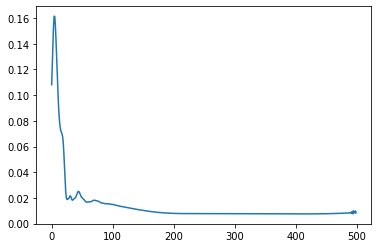

In [12]:
plt.plot(lstm_test_losses)

In [13]:
gru_epochs, gru_train_losses, gru_test_losses = train_test(gru, criterion, gru_optimizer, x_train, y_train, num_epochs, learning_rate)

Epoch: 1 , Train_loss: 0.02348 , Test_loss: 0.09388
Epoch: 2 , Train_loss: 0.02359 , Test_loss: 0.09880
Epoch: 3 , Train_loss: 0.02125 , Test_loss: 0.10766
Epoch: 4 , Train_loss: 0.01973 , Test_loss: 0.11072
Epoch: 5 , Train_loss: 0.01902 , Test_loss: 0.10383
Epoch: 6 , Train_loss: 0.01789 , Test_loss: 0.09028
Epoch: 7 , Train_loss: 0.01637 , Test_loss: 0.07489
Epoch: 8 , Train_loss: 0.01508 , Test_loss: 0.06204
Epoch: 9 , Train_loss: 0.01418 , Test_loss: 0.05407
Epoch: 10 , Train_loss: 0.01320 , Test_loss: 0.05023
Epoch: 11 , Train_loss: 0.01190 , Test_loss: 0.04867
Epoch: 12 , Train_loss: 0.01060 , Test_loss: 0.04724
Epoch: 13 , Train_loss: 0.00957 , Test_loss: 0.04376
Epoch: 14 , Train_loss: 0.00870 , Test_loss: 0.03741
Epoch: 15 , Train_loss: 0.00770 , Test_loss: 0.02958
Epoch: 16 , Train_loss: 0.00665 , Test_loss: 0.02280
Epoch: 17 , Train_loss: 0.00588 , Test_loss: 0.01886
Epoch: 18 , Train_loss: 0.00539 , Test_loss: 0.01745
Epoch: 19 , Train_loss: 0.00490 , Test_loss: 0.01730
Ep

## 6. *Compare LSTM and GRU loss*

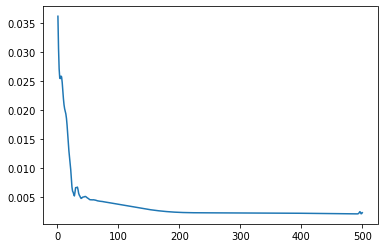

In [14]:
plt.plot(lstm_epochs, lstm_train_losses)

[Text(-100.0, 0, ''),
 Text(0.0, 0, ''),
 Text(100.0, 0, ''),
 Text(200.0, 0, ''),
 Text(300.0, 0, ''),
 Text(400.0, 0, ''),
 Text(500.0, 0, ''),
 Text(600.0, 0, '')]

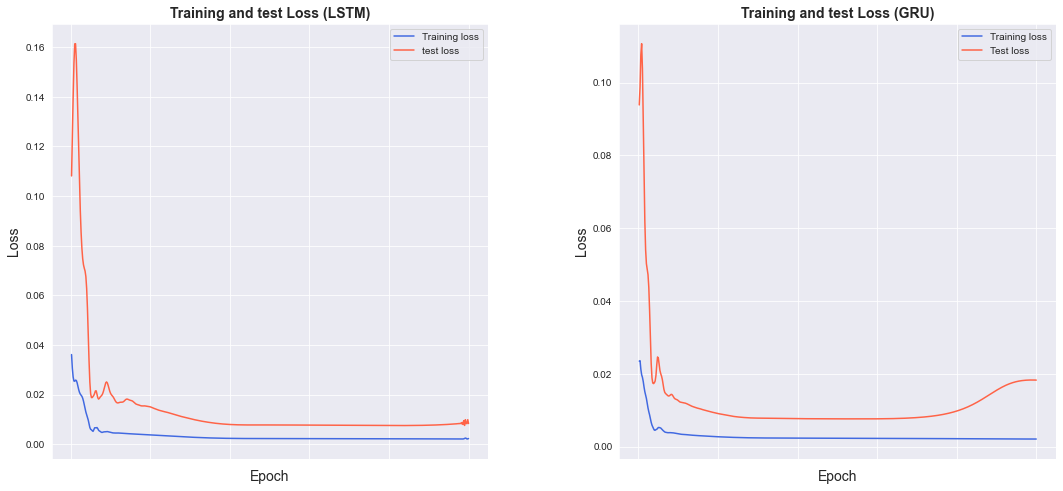

In [15]:
sns.set_style("darkgrid")    

fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = lstm_epochs, y = lstm_train_losses, label="Training loss", color="royalblue")
ax = sns.lineplot(x = lstm_epochs, y = lstm_test_losses, label="test loss", color="tomato")
ax.set_title("Training and test Loss (LSTM)", size = 14, fontweight="bold")
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(x = gru_epochs, y = gru_train_losses, label="Training loss", color="royalblue")
ax = sns.lineplot(x = gru_epochs, y = gru_test_losses, label="Test loss", color="tomato")
ax.set_title("Training and test Loss (GRU)", size = 14, fontweight="bold")
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_xticklabels('', size=10)

### 7. *Make predictions*

In [17]:
x_data = torch.Tensor(np.array(x))
y_data = torch.Tensor(np.array(y))

y_data = pd.DataFrame(scaler.inverse_transform(y_data.detach().numpy()))
# y_data = pd.DataFrame(y_data.detach().numpy())

lstm_data_predict = lstm(x_data).detach().numpy()
gru_data_predict = gru(x_data).detach().numpy()

lstm_data_predict = pd.DataFrame(scaler.inverse_transform(lstm_data_predict))
gru_data_predict = pd.DataFrame(scaler.inverse_transform(gru_data_predict))
# lstm_data_predict = pd.DataFrame(lstm_data_predict)
# gru_data_predict = pd.DataFrame(gru_data_predict)

## 8. *Compare LSTM and GRU prediction results*

[Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, ''),
 Text(120.0, 0, ''),
 Text(140.0, 0, ''),
 Text(160.0, 0, '')]

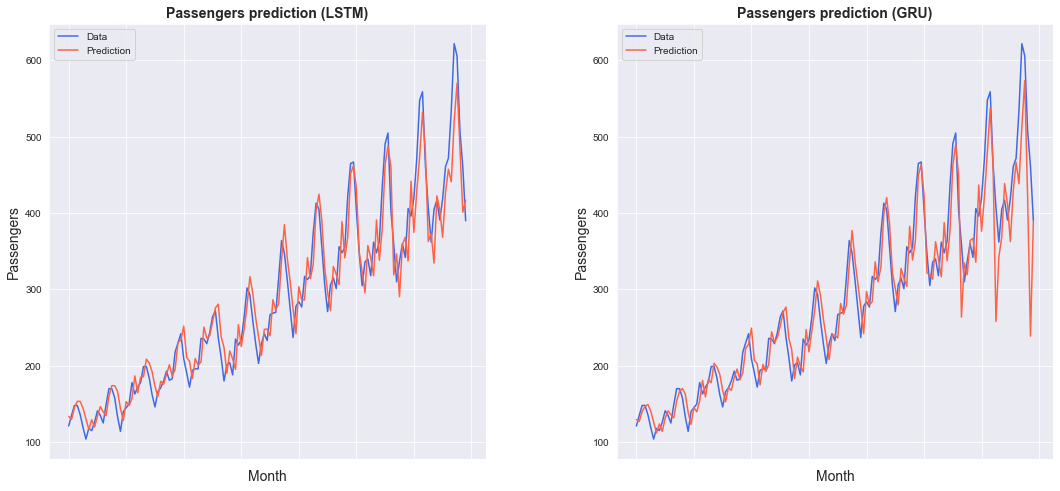

In [18]:
sns.set_style("darkgrid")    

fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = y_data.index, y = y_data[0], label="Data", color="royalblue")
ax = sns.lineplot(x = lstm_data_predict.index, y = lstm_data_predict[0], label="Prediction", color="tomato")
ax.set_title("Passengers prediction (LSTM)", size = 14, fontweight="bold")
ax.set_xlabel("Month", size = 14)
ax.set_ylabel("Passengers", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(x = y_data.index, y = y_data[0], label="Data", color="royalblue")
ax = sns.lineplot(x = gru_data_predict.index, y = gru_data_predict[0], label="Prediction", color="tomato")
ax.set_title("Passengers prediction (GRU)", size = 14, fontweight="bold")
ax.set_xlabel("Month", size = 14)
ax.set_ylabel("Passengers", size = 14)
ax.set_xticklabels('', size=10)